# Reconstruction of DWI data
Roberto Toro, March 2017

Two issues: interpolate a missing direction from the remaining ones, and interpolate missing sub regions of one direction from the remaining data.

In [1]:
%pylab inline
import urllib2 as url
import re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt
from StringIO import StringIO
import json

# Install seaborn typing `conda install seaborn`
import seaborn as sns

# Install nilearn and nibabel typing `pip install nilearn`
import nibabel as nib
import nilearn
from nilearn import plotting

# To add javascript code
from IPython.display import Javascript

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
fdwi = nib.load('/Users/roberto/Desktop/ferret-dti/F21_P16.nii.gz')
data = fdwi.get_data()

In [29]:
print(data.shape)
print(fdwi.get_header().get_zooms()[:3])

(200, 100, 75, 210)
(0.23999999, 0.23999999, 0.23999999)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  from ipykernel import kernelapp as app


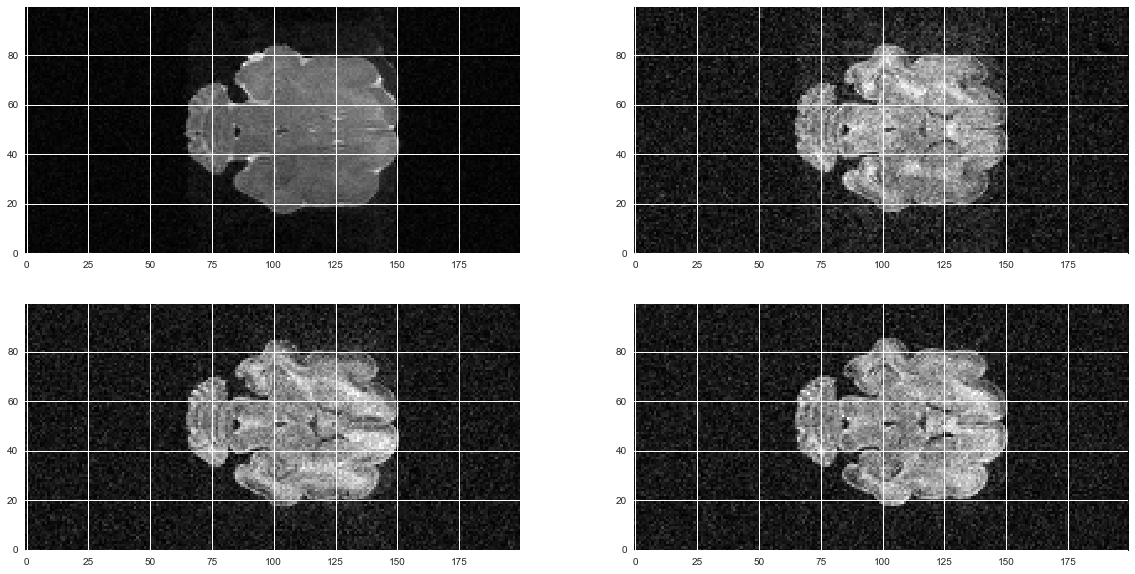

In [31]:
pylab.rcParams['figure.figsize'] = (20, 10)
axial_middle = data.shape[2] / 2
plt.subplot(2, 2, 1)
plt.imshow(data[:, :, axial_middle, 0].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 2)
plt.imshow(data[:, :, axial_middle, 10].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3)
plt.imshow(data[:, :, axial_middle, 20].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4)
plt.imshow(data[:, :, axial_middle, 30].T, cmap='gray', origin='lower')

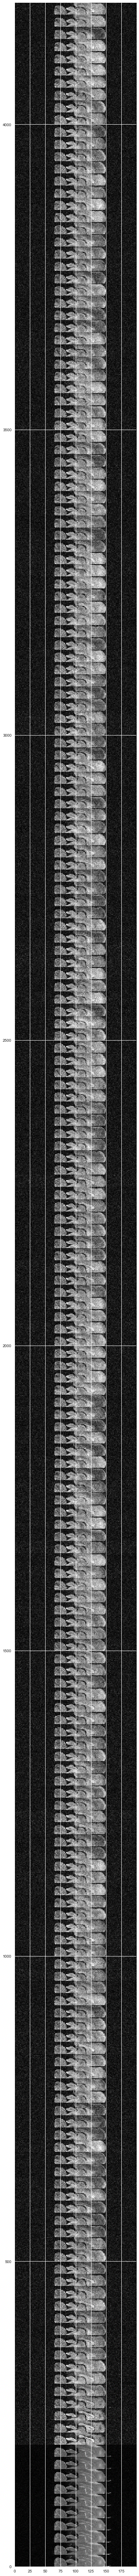

In [37]:
pylab.rcParams['figure.figsize'] = (120, 120)
N=210
th=20
slice=np.ndarray((data.shape[0],th*N));
for i in range(0,N):
    slice[:,(th*i):(th*i+th)]= data[:,50,30:(30+th),i];
plt.imshow(slice.T, cmap='gray', origin='lower')

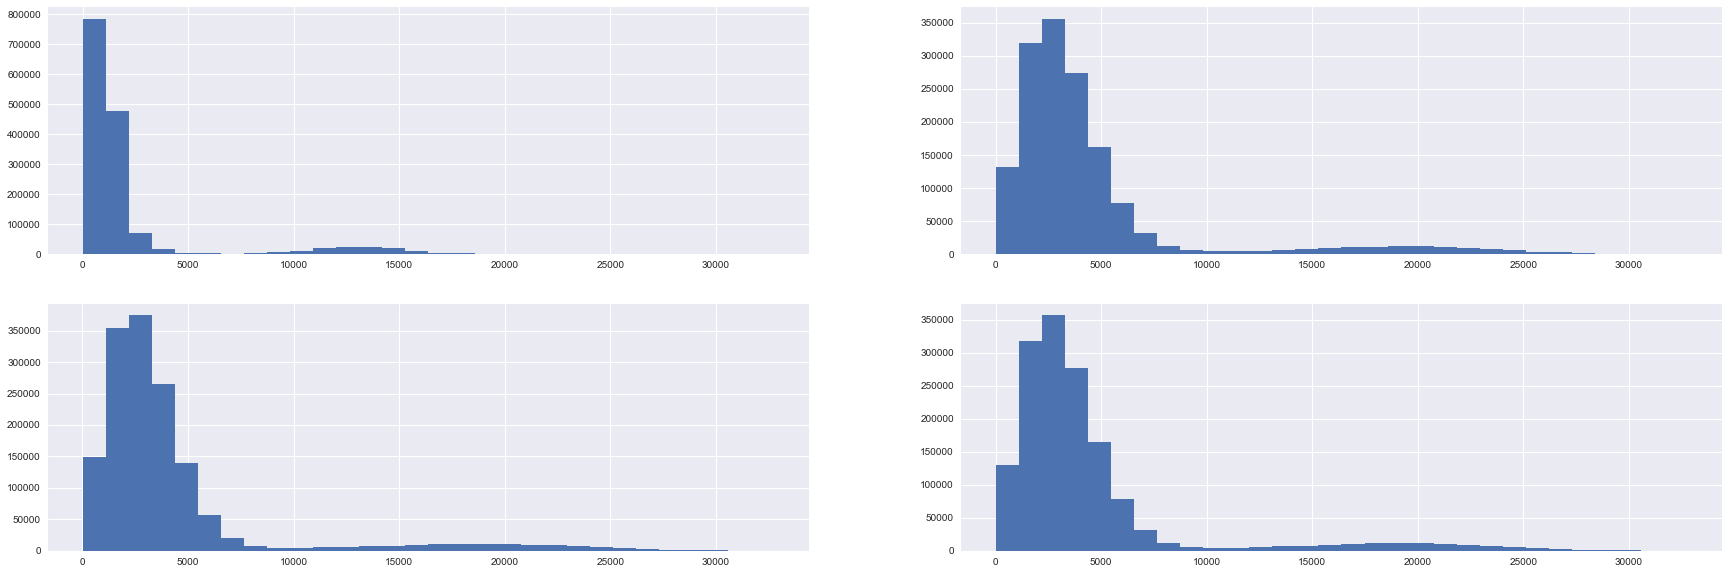

In [38]:
pylab.rcParams['figure.figsize'] = (30, 10)
plt.subplot(2, 2, 1)
plt.hist(data[:, :, :, 0].flatten(),bins=30);
plt.subplot(2, 2, 2)
plt.hist(data[:, :, :, 10].flatten(),bins=30);
plt.subplot(2, 2, 3)
plt.hist(data[:, :, :, 20].flatten(),bins=30);
plt.subplot(2, 2, 4)
plt.hist(data[:, :, :, 30].flatten(),bins=30);


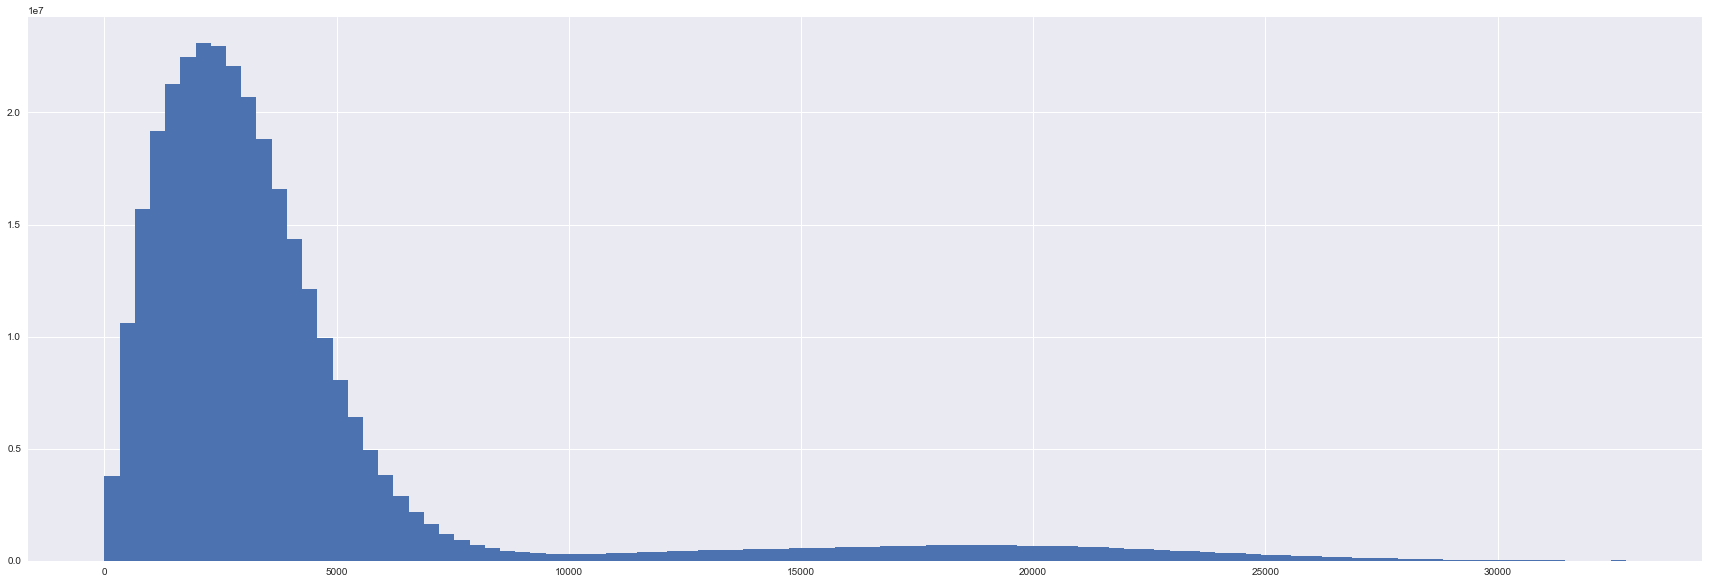

In [39]:
plt.hist(data.flatten(),bins=100);

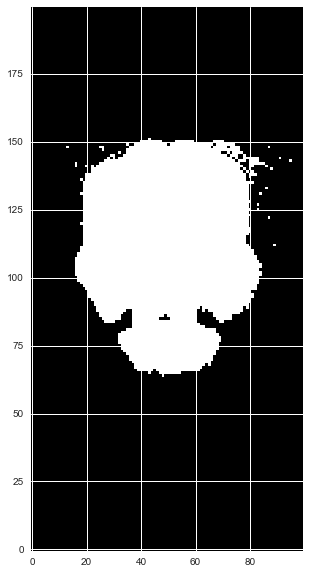

In [44]:
mask = data[..., 0] > 5000
plt.imshow(mask[:, :, axial_middle], cmap='gray', origin='lower')

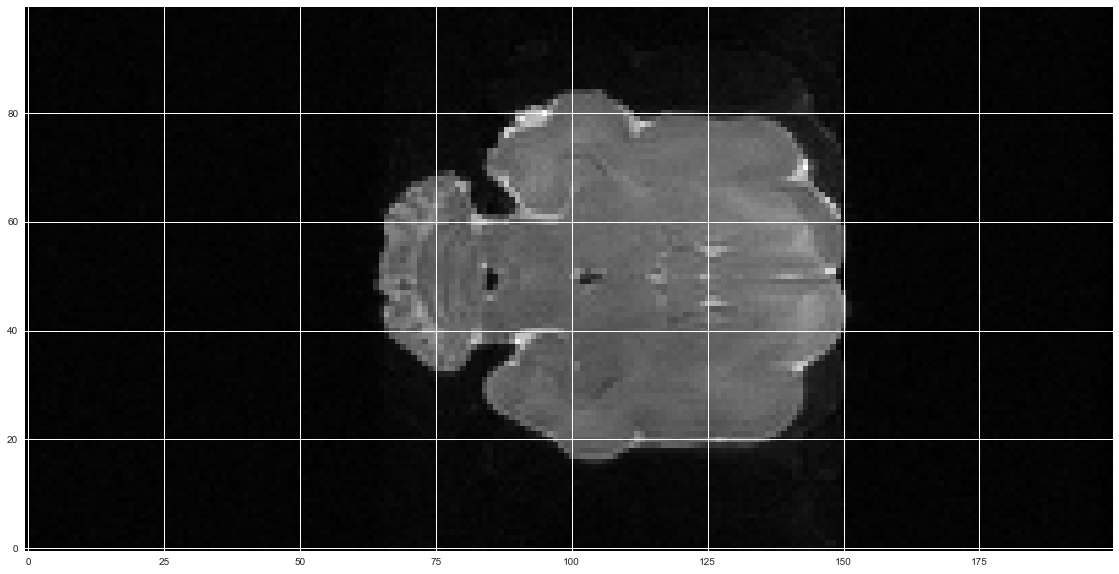

In [45]:
ad=data[...,0]*0.1
ad=ad+data[...,1]*0.1
ad=ad+data[...,2]*0.1
ad=ad+data[...,3]*0.1
ad=ad+data[...,4]*0.1
ad=ad+data[...,5]*0.1
ad=ad+data[...,6]*0.1
ad=ad+data[...,7]*0.1
ad=ad+data[...,8]*0.1
ad=ad+data[...,9]*0.1
plt.imshow(ad[:, :, axial_middle].T, cmap='gray', origin='lower')

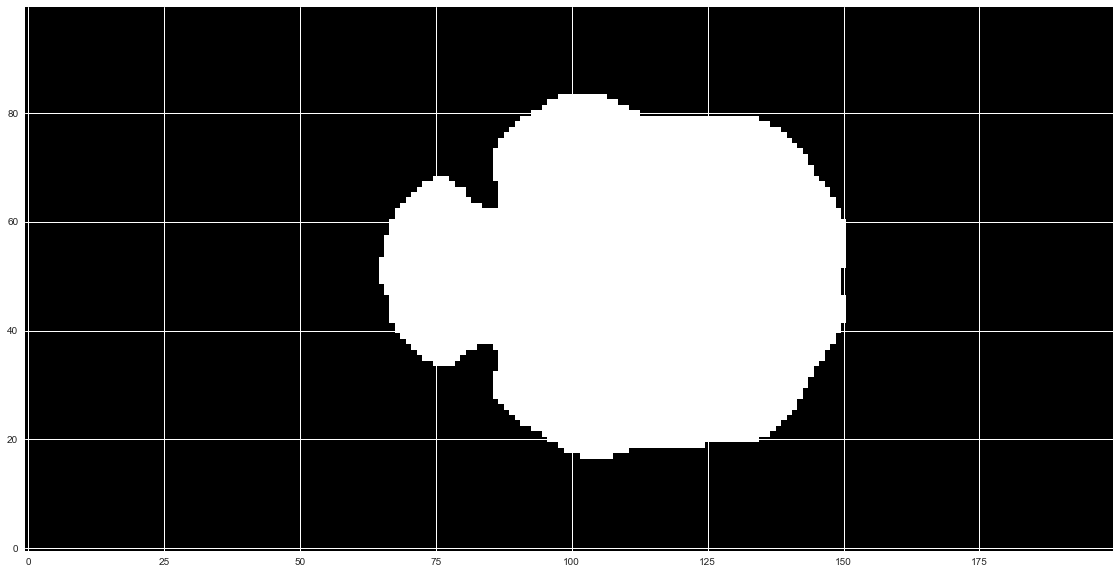

In [46]:
from dipy.segment.mask import median_otsu
b0_mask, mask = median_otsu(ad,2,2)
plt.imshow(mask[:, :, axial_middle].T, cmap='gray', origin='lower')

In [47]:
from dipy.denoise.noise_estimate import estimate_sigma
sigma = estimate_sigma(data[...,10])
print(sigma)

[ 1789.59631348]


In [25]:
from dipy.denoise.nlmeans import nlmeans
for i in range(10,210):
    print(i);
    data[...,i]=nlmeans(data[...,i], sigma=sigma, mask=mask)

pylab.rcParams['figure.figsize'] = (30, 30)

plt.subplot(3, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(3, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle].T, cmap='gray', origin='lower')

plt.subplot(3, 2, 3).set_axis_off()
plt.imshow(noi20[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(3, 2, 4).set_axis_off()
plt.imshow(den20[:, :, axial_middle].T, cmap='gray', origin='lower')

plt.subplot(3, 2, 5).set_axis_off()
plt.imshow(noi30[:, :, axial_middle].T, cmap='gray', origin='lower')
plt.subplot(3, 2, 6).set_axis_off()
plt.imshow(den30[:, :, axial_middle].T, cmap='gray', origin='lower')

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


IndexError: index 210 is out of bounds for axis 3 with size 210

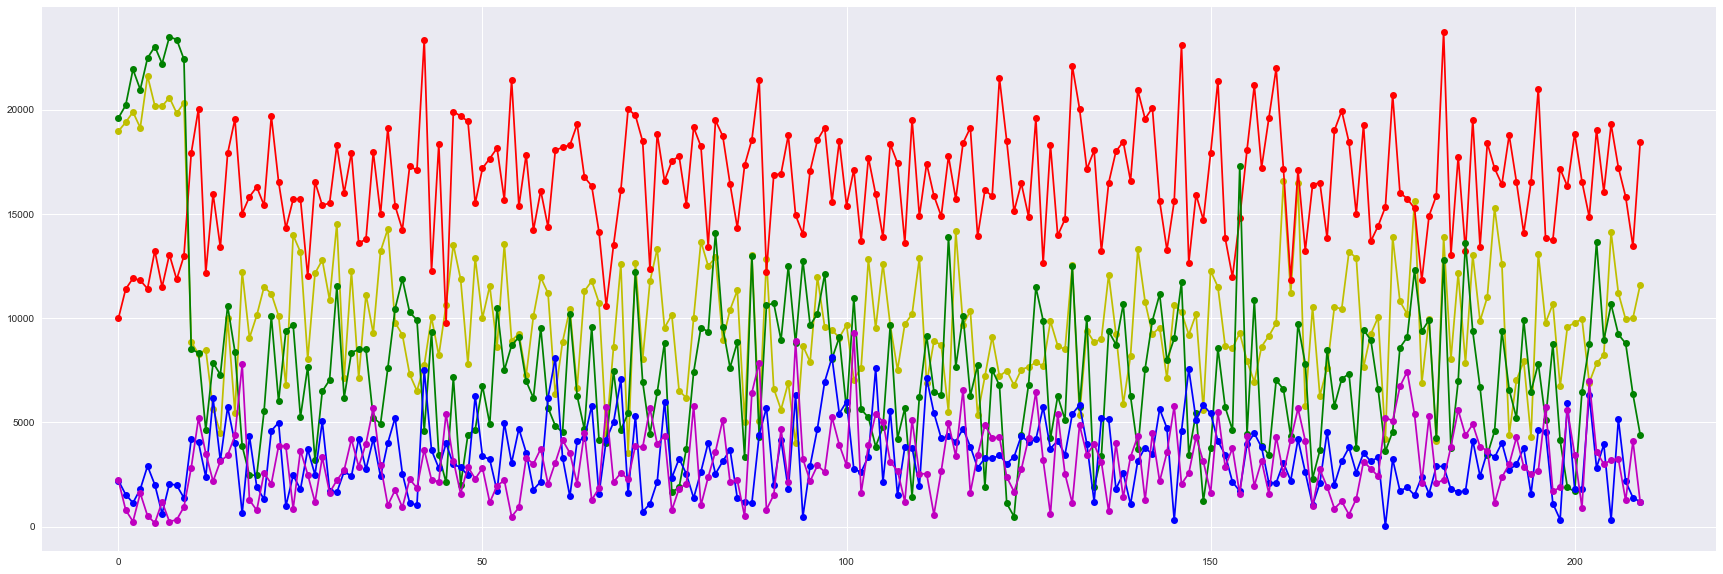

In [49]:
pylab.rcParams['figure.figsize'] = (30, 10)
plt.plot(data[80,40,40,:],'yo-')
plt.plot(data[80,50,40,:],'ro-')
plt.plot(data[80,60,40,:],'go-')
plt.plot(data[80,70,40,:],'bo-')
plt.plot(data[80,80,40,:],'mo-')

In [51]:
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs('/Users/roberto/Desktop/ferret-dti/F21_P16.bvals', '/Users/roberto/Desktop/ferret-dti/F21_P16.bvecs')
print(bvals.shape,bvecs.shape)
bvals[0:10]=0

((210,), (210, 3))


In [52]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [53]:
gtab.b0s_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [54]:
from dipy.reconst.dti import TensorModel
ten = TensorModel(gtab)
tenfit = ten.fit(data)

In [58]:
print(data[...].min(),data[...].max())

(0, 32766)


In [56]:
from dipy.reconst.dti import fractional_anisotropy, color_fa

fa = fractional_anisotropy(tenfit.evals)
fa = np.clip(fa, 0, 1)
fa[np.isnan(fa)] = 0

cfa = color_fa(fa, tenfit.evecs)

md = tenfit.md

(array([  1.48088100e+06,   6.14700000e+03,   5.33500000e+03,
          4.75500000e+03,   2.29500000e+03,   5.61000000e+02,
          1.80000000e+01,   5.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([  4.70713213e-10,   2.04890798e-04,   4.09781125e-04,
          6.14671453e-04,   8.19561780e-04,   1.02445211e-03,
          1.22934243e-03,   1.43423276e-03,   1.63912309e-03,
          1.84401342e-03,   2.04890374e-03]),
 <a list of 10 Patch objects>)

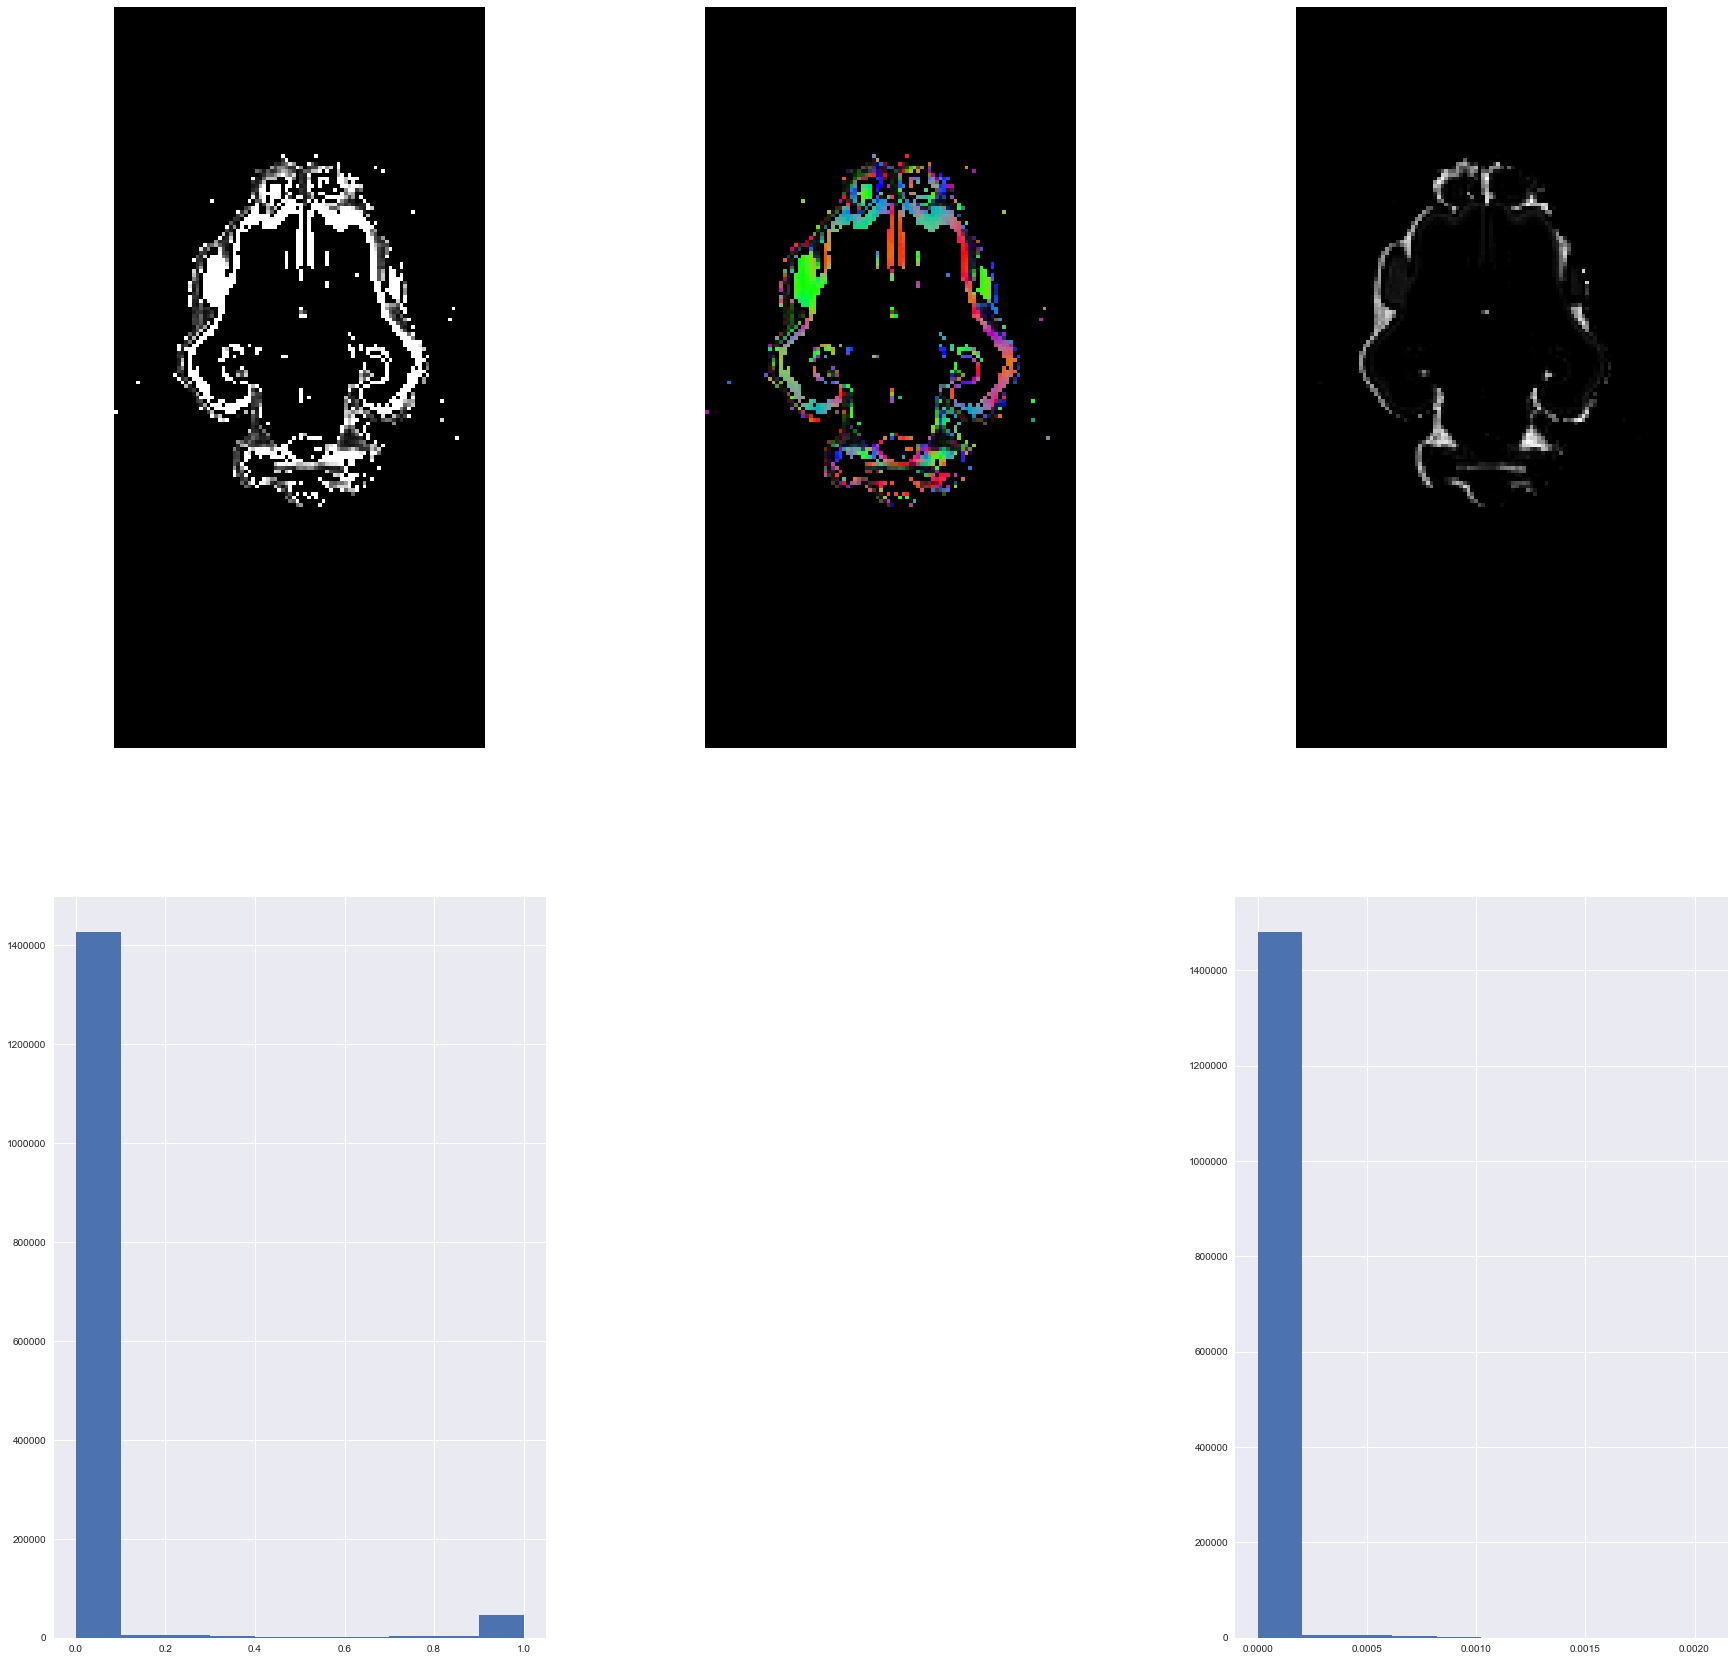

In [57]:
pylab.rcParams['figure.figsize'] = (30, 30)
fig=plt.figure()
plt.subplot(2, 3, 1).set_axis_off()
plt.imshow(fa[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 2).set_axis_off()
plt.imshow(cfa[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 3).set_axis_off()
plt.imshow(md[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 4)
plt.hist(fa.flatten())
plt.subplot(2, 3, 6)
plt.hist(md.flatten())

In [108]:
fa_img = nib.Nifti1Image(fa.astype(np.float32), fdwi.get_affine())
nib.save(fa_img, '/Users/roberto/Desktop/tensor_fa.nii.gz')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if __name__ == '__main__':


In [109]:
md_img = nib.Nifti1Image(md.astype(np.float32), fdwi.get_affine())
nib.save(md_img, '/Users/roberto/Desktop/dipy_md.nii.gz')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if __name__ == '__main__':


In [110]:
tenfit.evals.shape

(160, 120, 80, 3)

In [112]:
l1_img = nib.Nifti1Image(tenfit.evals[...,0].astype(np.float32), fdwi.get_affine())
nib.save(l1_img, '/Users/roberto/Desktop/dipy_l1.nii.gz')
l2_img = nib.Nifti1Image(tenfit.evals[...,1].astype(np.float32), fdwi.get_affine())
nib.save(l2_img, '/Users/roberto/Desktop/dipy_l2.nii.gz')
l3_img = nib.Nifti1Image(tenfit.evals[...,2].astype(np.float32), fdwi.get_affine())
nib.save(l3_img, '/Users/roberto/Desktop/dipy_l3.nii.gz')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


In [96]:
print(md[...].min(),md[...].max())

(2.4384819693863504e-10, 0.0025728337599256615)


In [104]:
tenfit.evals[...,2].min()

2.4384819693863504e-10

In [ ]:
from dipy.data import fetch_sherbrooke_3shell
fetch_sherbrooke_3shell()

In [82]:
fdwi2 = nib.load('/Users/roberto/.dipy/sherbrooke_3shell/HARDI193.nii.gz')
data2 = fdwi2.get_data()
print(data2.shape)
print(fdwi2.get_header().get_zooms()[:3])

(128, 128, 60, 193)
(2.0, 2.0, 2.0)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0


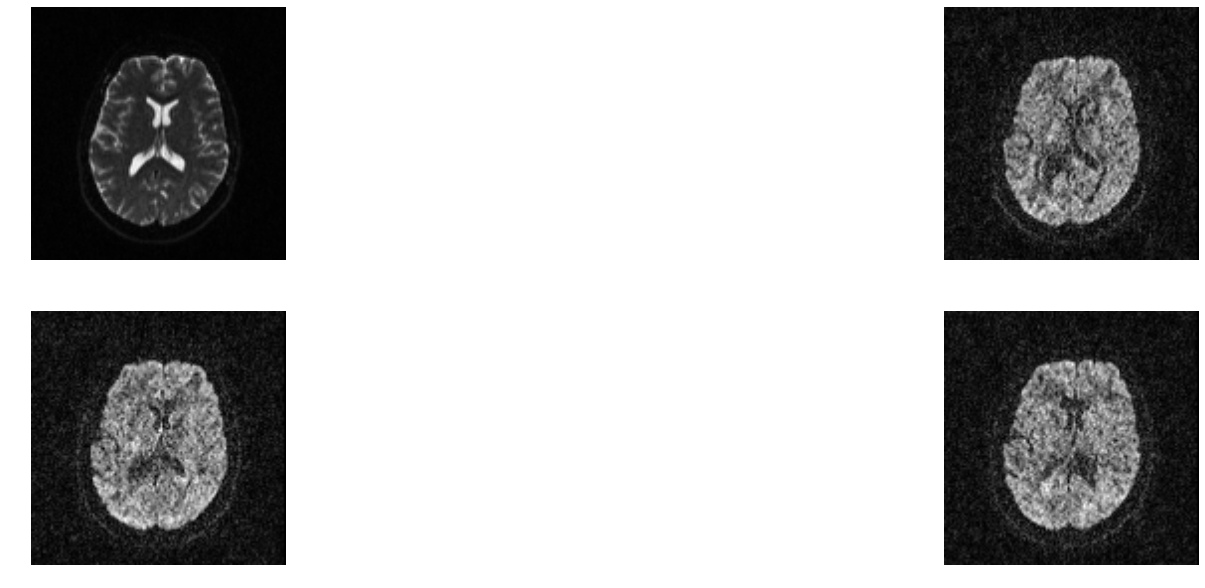

In [83]:
axial_middle = data2.shape[2] / 2
plt.subplot(2, 2, 1).set_axis_off()
plt.imshow(data2[:, :, 30, 0].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 2).set_axis_off()
plt.imshow(data2[:, :, 30, 10].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off()
plt.imshow(data2[:, :, 30, 20].T, cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off()
plt.imshow(data2[:, :, 30, 30].T, cmap='gray', origin='lower')

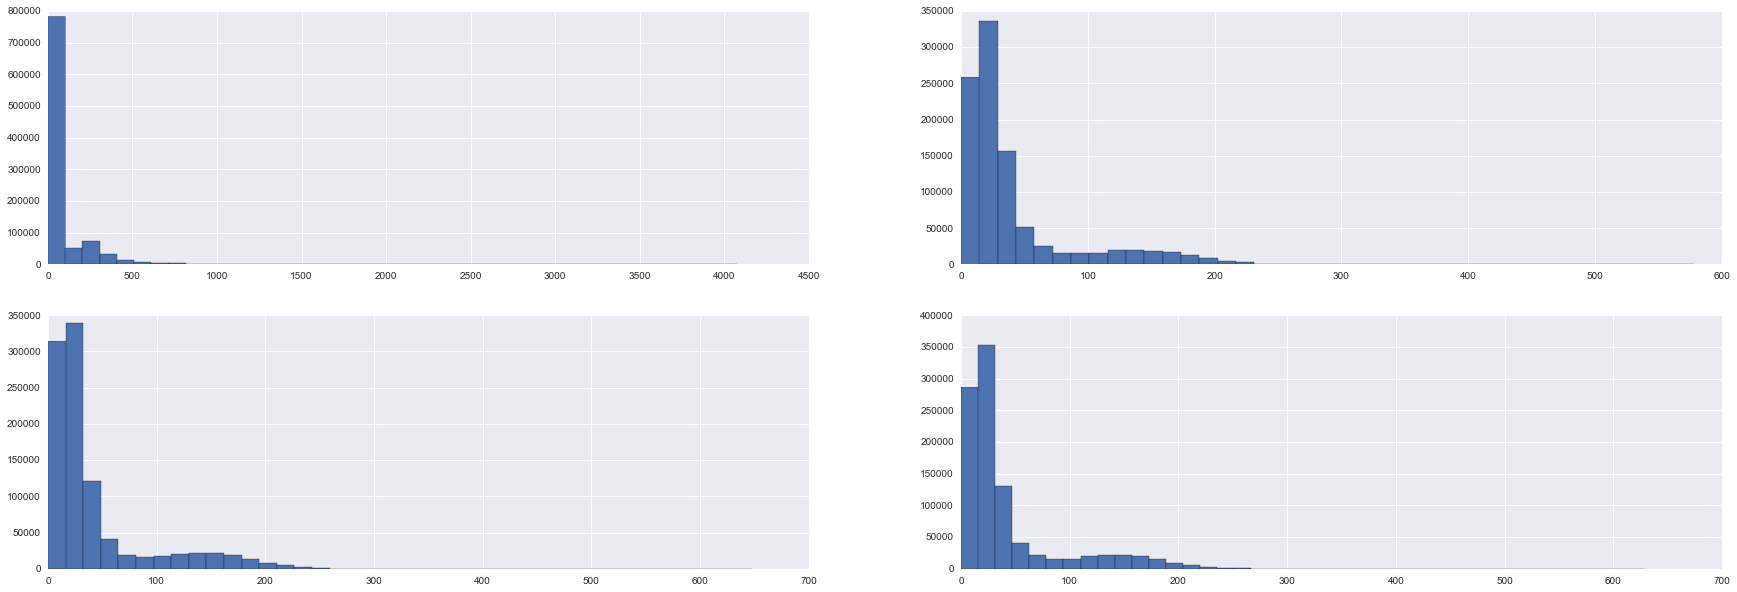

In [86]:
pylab.rcParams['figure.figsize'] = (30, 10)
plt.subplot(2, 2, 1)
plt.hist(data2[:, :, :, 0].flatten(),40);
plt.subplot(2, 2, 2)
plt.hist(data2[:, :, :, 10].flatten(),40);
plt.subplot(2, 2, 3)
plt.hist(data2[:, :, :, 20].flatten(),40);
plt.subplot(2, 2, 4)
plt.hist(data2[:, :, :, 30].flatten(),40);


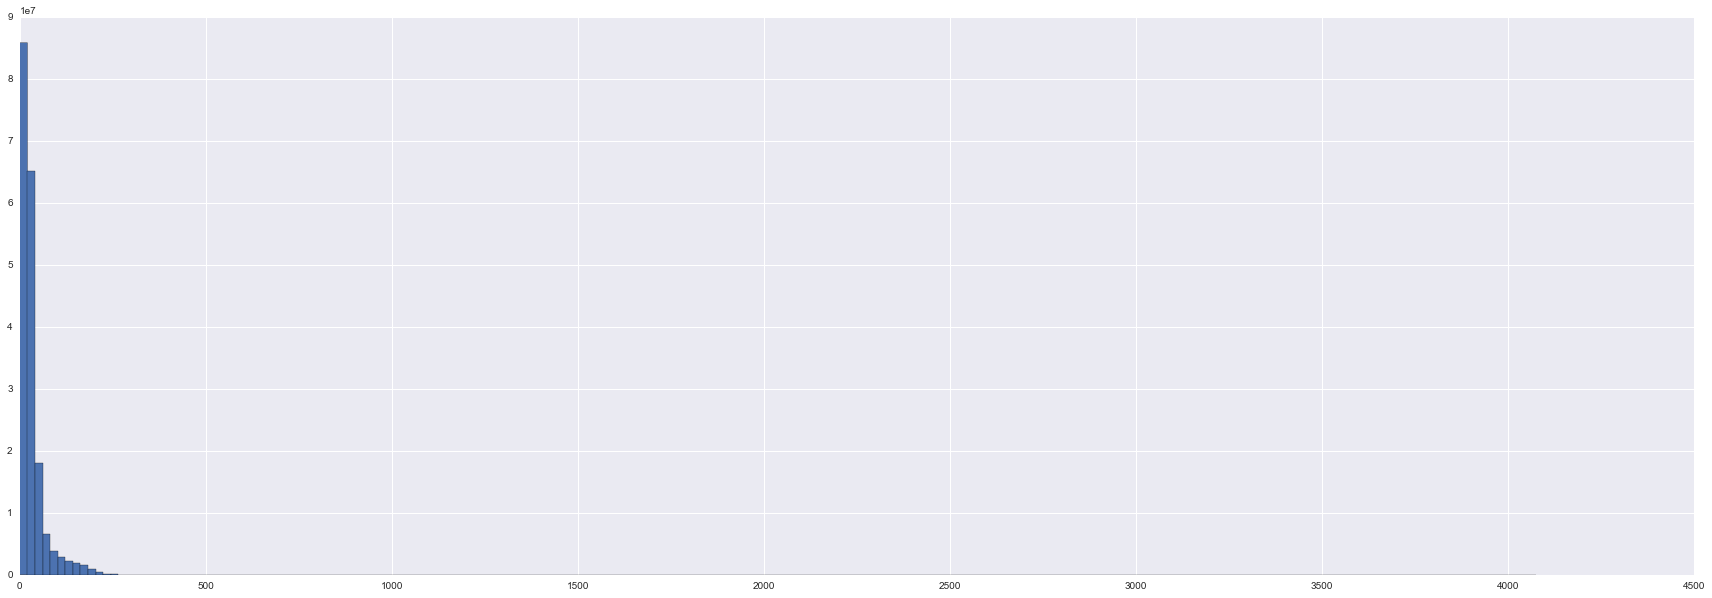

In [88]:
plt.hist(data2.flatten(),bins=200);

In [89]:
from dipy.io import read_bvals_bvecs
bvals2, bvecs2 = read_bvals_bvecs('/Users/roberto/.dipy/sherbrooke_3shell/HARDI193.bval', '/Users/roberto/.dipy/sherbrooke_3shell/HARDI193.bvec')
print(bvals2.shape,bvecs2.shape)

from dipy.core.gradients import gradient_table
gtab2 = gradient_table(bvals2, bvecs2)

((193,), (193, 3))


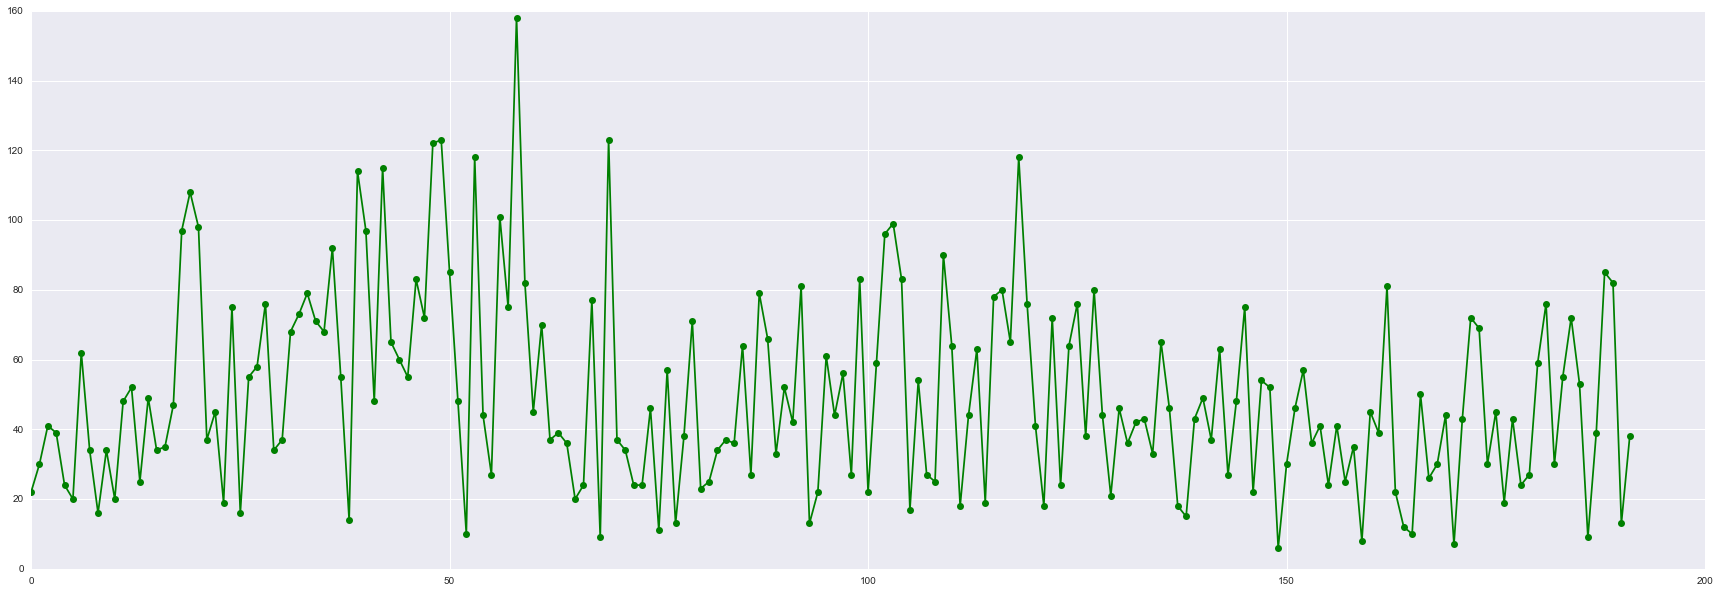

In [90]:
pylab.rcParams['figure.figsize'] = (30, 10)
#plt.plot(data2[64,40,30,1:],'yo-')
#plt.plot(data2[64,50,30,1:],'ro-')
plt.plot(data2[64,60,30,1:],'go-')
#plt.plot(data2[64,70,30,1:],'bo-')
#plt.plot(data2[64,80,30,1:],'mo-')

In [91]:
from dipy.reconst.dti import TensorModel
ten2 = TensorModel(gtab2)
tenfit2 = ten2.fit(data2)

(array([  4.71585000e+05,   2.06840000e+05,   7.77110000e+04,
          2.88460000e+04,   1.28600000e+04,   8.59300000e+03,
          7.17600000e+03,   6.98100000e+03,   1.03000000e+04,
          1.75730000e+04,   2.26590000e+04,   2.38520000e+04,
          2.26420000e+04,   2.02960000e+04,   1.70070000e+04,
          1.14540000e+04,   6.59700000e+03,   3.90200000e+03,
          2.51600000e+03,   1.56700000e+03,   9.54000000e+02,
          5.29000000e+02,   3.07000000e+02,   1.48000000e+02,
          8.30000000e+01,   4.40000000e+01,   1.20000000e+01,
          3.00000000e+00,   2.00000000e+00,   1.00000000e+00]),
 array([  2.85718857e-10,   4.85346087e-05,   9.70689317e-05,
          1.45603255e-04,   1.94137578e-04,   2.42671901e-04,
          2.91206224e-04,   3.39740547e-04,   3.88274870e-04,
          4.36809193e-04,   4.85343516e-04,   5.33877839e-04,
          5.82412162e-04,   6.30946485e-04,   6.79480808e-04,
          7.28015131e-04,   7.76549454e-04,   8.25083777e-04,
      

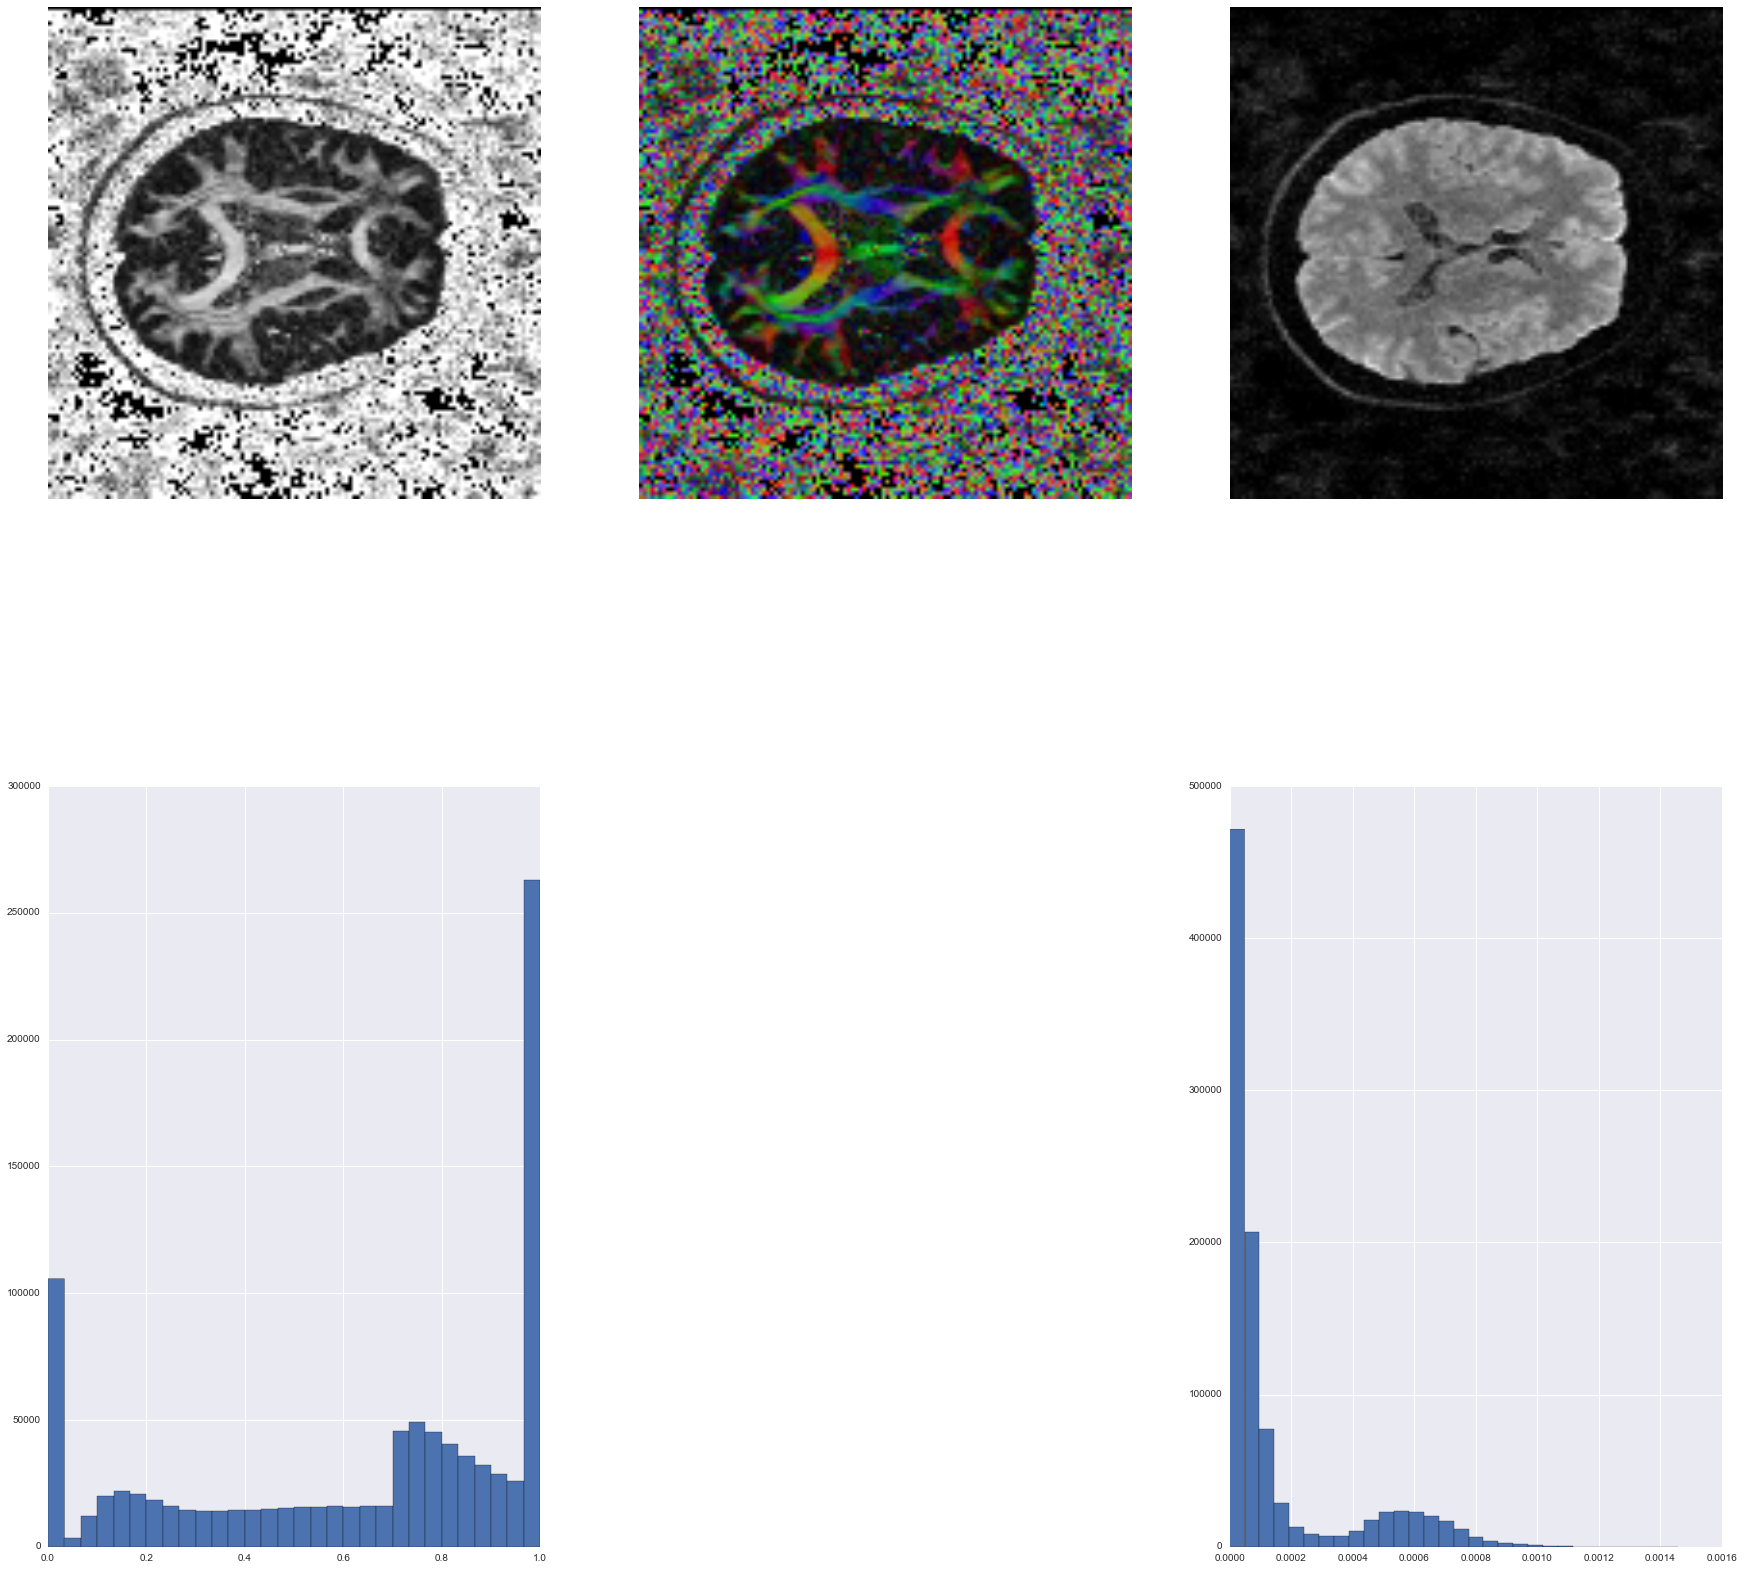

In [92]:
from dipy.reconst.dti import fractional_anisotropy, color_fa

fa2 = fractional_anisotropy(tenfit2.evals)
fa2 = np.clip(fa2, 0, 1)
fa2[np.isnan(fa2)] = 0

cfa2 = color_fa(fa2, tenfit2.evecs)

md2 = tenfit2.md

pylab.rcParams['figure.figsize'] = (30, 30)
fig=plt.figure()
plt.subplot(2, 3, 1).set_axis_off()
plt.imshow(fa2[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 2).set_axis_off()
plt.imshow(cfa2[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 3).set_axis_off()
plt.imshow(md2[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 4)
plt.hist(fa2.flatten(),30)
plt.subplot(2, 3, 6)
plt.hist(md2.flatten(),30)

In [95]:
print(md2[...].min(),md2[...].max())

(2.8571885719771486e-10, 0.0014560299760245374)


In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
def imshowcluster(D):
    # Based on http://stackoverflow.com/questions/2982929/plotting-results-of-hierarchical-clustering-ontop-of-a-matrix-of-data-in-python
    fig = plt.figure()

    # Compute and plot dendrogram.
    axdendro1 = fig.add_axes([0.0,0.2,0.19,0.8])
    Y1 = sch.linkage(D, method='centroid')
    Z1 = sch.dendrogram(Y1, orientation='right')
    axdendro1.set_xticks([])
    axdendro1.set_yticks([])

    # Compute and plot dendrogram.
    axdendro2 = fig.add_axes([0.2,0.00,0.6,0.19])
    Y2 = sch.linkage(D.transpose(), method='centroid')
    Z2 = sch.dendrogram(Y2, orientation='bottom')
    axdendro2.set_xticks([])
    axdendro2.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.2,0.2,0.6,0.8])
    idx1 = Z1['leaves']
    idx2 = Z2['leaves']
    D = D[idx1,:]
    D = D[:,idx2]
    im = axmatrix.matshow(D, aspect='auto', origin='lower')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
    plt.colorbar(im, cax=axcolor)

    # Add axes labels
    axmatrix.set_xticks(range(D.shape[0]))
    axmatrix.set_xticklabels(idx1, minor=False)
    axmatrix.xaxis.set_label_position('bottom')
    axmatrix.xaxis.tick_bottom()

    plt.xticks(rotation=-90, fontsize=4)

    axmatrix.set_yticks(range(D.shape[1]))
    axmatrix.set_yticklabels(idx2, minor=False)
    axmatrix.yaxis.set_label_position('right')
    axmatrix.yaxis.tick_right()
    # Display and save figure.
    #fig.savefig('dendrogram.png')

In [ ]:
pylab.rcParams['figure.figsize'] = (30, 30)

In [ ]:
D = bvecs.dot(bvecs.T); # compute similarity matrix
Y = sch.linkage(D, method='centroid'); # cluster it
idx = sch.leaves_list(Y); # get index list for the leaves
D = D[idx,:]; # sort the matrix
D = D[:,idx];
fig = plt.figure() # plot it
axmatrix = fig.add_axes([0,0,1,1])
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(im) # plot the colour map

In [ ]:
plt.plot(data[80,40,40,idx],'yo:')

## Inject d3

### 1. Import d3

In [ ]:
%%javascript
require.config({
    paths: {
        d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
    }
})

// convert to_json format into d3 format
// from https://github.com/cmoscardi/embedded_d3_example/blob/master/Embedded_D3.ipynb
function convertPlotData(data){
  var convertedData = [];
  //pandas gives each column the same number of
  //objects, arbitrarily choose one to iterate over
  for(var i in data[Object.keys(data)[0]]){
    var convertedDatum = {};
    for(var key in data){
      convertedDatum[key] = data[key][i];
    }
    convertedData.push(convertedDatum);
  }
  return convertedData;
}

window.convertPlotData = convertPlotData;

### 2. Create a data frame and move it to the browser

In [ ]:
df=pd.DataFrame({'ala':[1,2,3,4,5],'bola':[5,4,3,2,1]});

In [ ]:
Javascript("""
           window.vizObj={};
           """.format(df.to_json()));

### 3. Display the data in the browser using d3

In [ ]:
%%javascript
element.append("<div id='chart1'>bibi</div>");
$("#chart1").text(JSON.stringify(convertPlotData(vizObj)));

## Inject three.js

### 1. Import three.js and TrackballControls

In [ ]:
%%javascript
define("three-glue", ["three"], function (three) {
    console.log('Doing it');
    window.THREE = three;
    return three;
});
require.config({
    paths: {
        three: 'https://cdnjs.cloudflare.com/ajax/libs/three.js/81/three.min'
    },
    map: {
        '*': {
            three: 'three-glue'
        },
        'three-glue': {
            three: 'three'
        }
    }
});
require(['three'],function(THREE) {
    $.getScript('https://cdn.rawgit.com/mrdoob/three.js/r81/examples/js/controls/TrackballControls.js')
    .then(function() {
        element.append("done");
    });
});

### 2. Move data from jupyter to the browser

In [ ]:
Javascript("""
           window.dirObj={};
           """.format(json.dumps(gtab.bvecs.tolist())))

### 3. Display using three.js

In [ ]:
%%javascript
console.log("Launching the render");
require(['three'],function(THREE) {    
    $('#brain').remove();
    element.append("<div id='brain' style='width:100%;height:512px'></div>");

    var	 renderer,scene, mesh, camera, trackball, geometry, cameraControl;
    renderer = new THREE.WebGLRenderer();
    var w=$("#brain").width();
    var h=$("#brain").height();
    console.log(w,h);
    renderer.setSize(w,h);

    $('#brain')[0].appendChild(renderer.domElement);
    scene = new THREE.Scene();
    scene.background = new THREE.Color( 0xffffff );
    camera = new THREE.PerspectiveCamera( 50, w/h, 1, 100);
    camera.position.z = 30;
    scene.add(camera);
    geometry = new THREE.SphereGeometry(0.5,16,16);
    for(var i=0;i<dirObj.length;i++) {
        var sph = new THREE.Mesh( geometry, new THREE.MeshNormalMaterial());
        sph.position.x=dirObj[i][0]*10;
        sph.position.y=dirObj[i][1]*10;
        sph.position.z=dirObj[i][2]*10;
        scene.add(sph);
    }

    cameraControl=new THREE.TrackballControls(camera,$('#brain')[0]);

    animate();

    function animate() {
        requestAnimationFrame( animate );
        render();
    }
    function render() {
        cameraControl.update();
        renderer.render( scene, camera );
    }
})  


## 4. Effect of using reco_map_slope to scale Bruker DWI data

In [49]:
dwidir='/Users/roberto/Documents/_04_Data/2006_02FerretBrain/ferret/dti-furetp32-18072014/'
raw='P32-no-scaling.nii.gz'
scaled='P32-scaled-denoised-debiased.nii.gz'

In [50]:
# Scaled
dwi = nib.load(dwidir+scaled)
data = dwi.get_data()
from dipy.io import read_bvals_bvecs
bvals, bvecs = read_bvals_bvecs(dwidir+'bvals', dwidir+'bvecs')
print(bvals.shape,bvecs.shape)
bvals[0:10]=0

((210,), (210, 3))


In [51]:
from dipy.core.gradients import gradient_table
gtab = gradient_table(bvals, bvecs)

In [52]:
from dipy.segment.mask import median_otsu
data_mask, mask = median_otsu(data,2,2)

In [53]:
data_mask.shape

(200, 100, 75, 210)

In [54]:
from dipy.reconst.dti import TensorModel
ten = TensorModel(gtab)
tenfit = ten.fit(data_mask)

In [55]:
from dipy.reconst.dti import fractional_anisotropy, color_fa

fa = fractional_anisotropy(tenfit.evals)
#fa = np.clip(fa, 0, 1)
#fa[np.isnan(fa)] = 0

cfa = color_fa(fa, tenfit.evecs)

md = tenfit.md

(array([  1.02907000e+06,   1.84827000e+05,   2.26191000e+05,
          2.67040000e+04,   9.82300000e+03,   8.46400000e+03,
          7.80200000e+03,   4.75700000e+03,   2.10400000e+03,
          2.58000000e+02]),
 array([  4.75905203e-10,   1.64590165e-04,   3.29179855e-04,
          4.93769545e-04,   6.58359234e-04,   8.22948924e-04,
          9.87538613e-04,   1.15212830e-03,   1.31671799e-03,
          1.48130768e-03,   1.64589737e-03]),
 <a list of 10 Patch objects>)

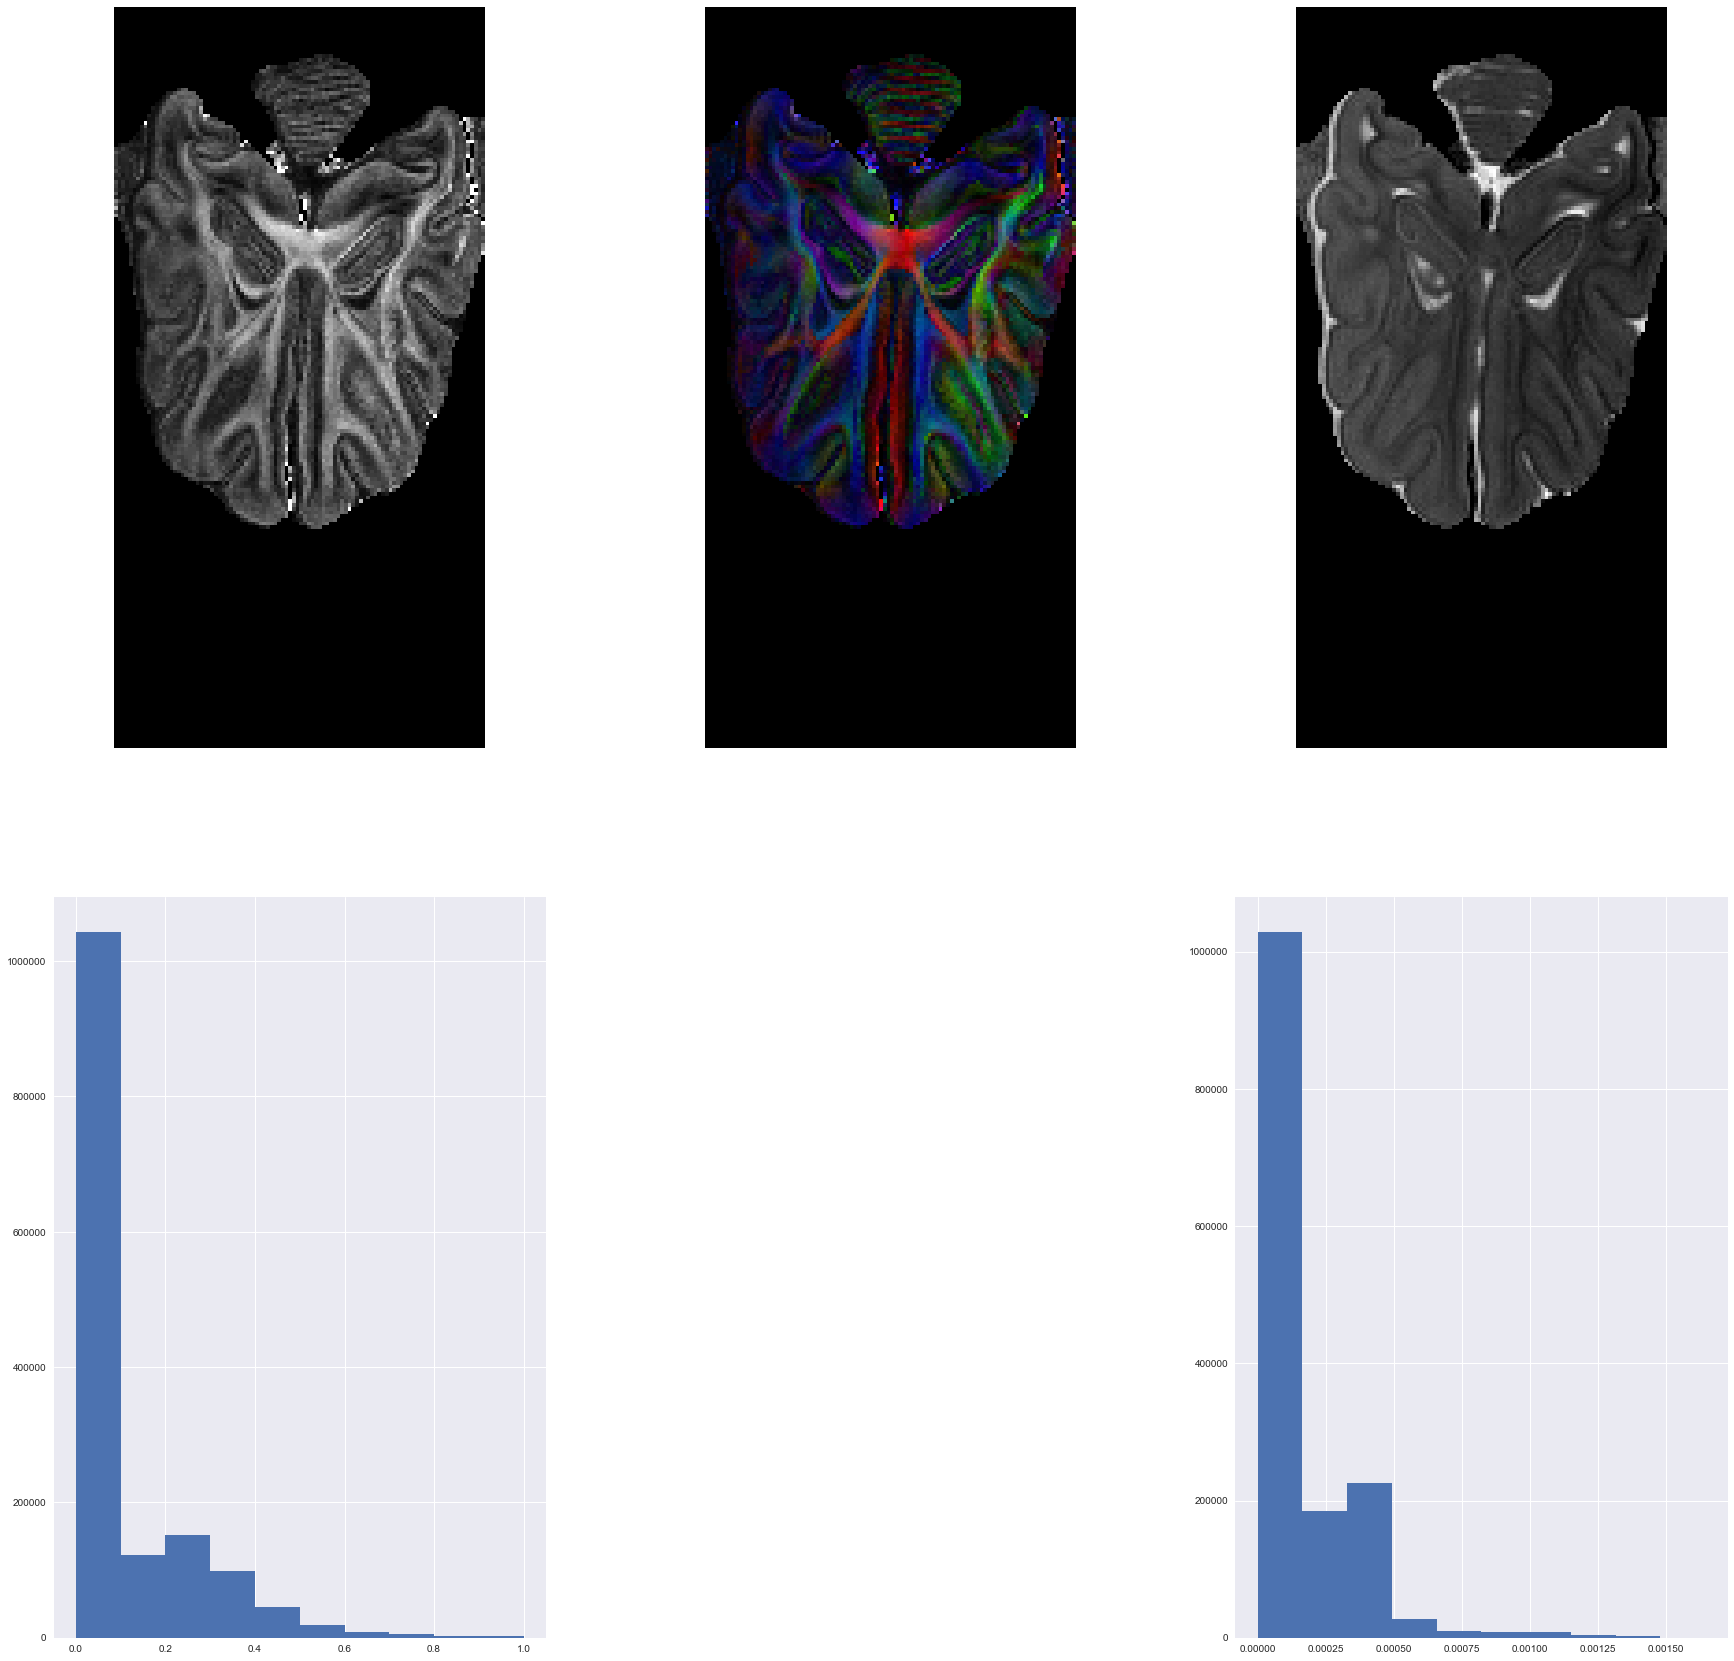

In [56]:
pylab.rcParams['figure.figsize'] = (30, 30)
fig=plt.figure()
plt.subplot(2, 3, 1).set_axis_off()
plt.imshow(fa[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 2).set_axis_off()
plt.imshow(cfa[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 3).set_axis_off()
plt.imshow(md[:, :, 30], cmap='gray', origin='lower')
plt.subplot(2, 3, 4)
plt.hist(fa.flatten())
plt.subplot(2, 3, 6)
plt.hist(md.flatten())

In [57]:
nib.save(nib.Nifti1Image(fa.astype(np.float32), dwi.affine),dwidir+'tensors_fa.nii.gz')
nib.save(nib.Nifti1Image(cfa.astype(np.float32), dwi.affine),dwidir+'tensors_cfa.nii.gz')